In [1]:
import glob
import os
import random
import pandas as pd
import shutil
import numpy as np
from tqdm import tqdm

In [2]:
annotation_files = [f for f in glob.glob("..\\..\\..\\data\\surf_only_images\\*.txt") if os.path.getsize(f) > 0]
annotation_files
#We annotated classified images. Each file should then contain at least one surfer, have at least one annotation

['..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-22_10-45.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-22_15-15.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-24_16-15.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-25_10-30.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-25_12-15.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-25_15-00.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-25_17-00.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-26_17-15.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-27_08-00.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-28_08-15.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-28_08-45.txt',
 '..\\..\\..\\data\\surf_only_images\\spots_Anglet_Gra

In [3]:
annotation_files_june_july = [f for f in glob.glob("..\\..\\..\\data\\subsample_from_2022-06-01_to_2022-07-12\\*.txt") if os.path.getsize(f) > 0 and "classes.txt" not in f]
annotation_files += annotation_files_june_july

In [4]:
print(len(annotation_files))
annotation_files[10]

235


'..\\..\\..\\data\\surf_only_images\\spots_Anglet_GrandePlage_2022-03-28_08-45.txt'

In [5]:
import random
random.shuffle(annotation_files)

In [6]:
from PIL import Image, ImageFile, ImageDraw
import re
import matplotlib.pyplot as plt


# expects yolo format
def display_image_in_actual_size(im, labels):
    dpi = 80
    #im_data = plt.imread(im_path)
    width, height = im.size

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
        
    # Hide spines, ticks, etc.
    ax.axis('off')    
    
    for bbox in labels:
        img_draw = ImageDraw.Draw(im)
        img_draw.rectangle(((width * (bbox[1] - bbox[3]/2), height * (bbox[2] - bbox[4]/2)),
                            (width * (bbox[1] + bbox[3]/2), height * (bbox[2] + bbox[4]/2))), 
                           outline='Red')

    # Display the image.
    ax.imshow(im, cmap='gray')
    plt.show()

In [7]:
def random_crops(n_random_crops, min_crop_size, max_crop_size):
    crops_centers = np.random.uniform(low=min_crop_size/2, high=1 - min_crop_size/2, size=(n_random_crops,2))
    crops_sizes = np.random.uniform(low=min_crop_size, high=max_crop_size, size=(n_random_crops,1))
    crops = np.concatenate((crops_centers - crops_sizes/2, crops_sizes, crops_sizes), axis=1)
    crops = crops.clip(min=0)  # clip min value
    for i in range(crops.shape[0]):
        if crops[i][0] + crops[i][2] > 1:
            crops[i][2] = 1 - crops[i][0]
        if crops[i][1] + crops[i][3] > 1:
            crops[i][3] = 1 - crops[i][1]
        # clip max values
    return crops


def bb_intersectionAB_over_A(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[1], boxB[0])
    yA = max(boxA[2], boxB[1])
    xB = min(boxA[1] + boxA[3], boxB[0] + boxB[2])
    yB = min(boxA[2] + boxA[4], boxB[1] + boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of A rectangle
    boxAArea = abs(boxA[3] * boxA[4])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    ioA = interArea / float(boxAArea)
    # return the intersection over A value
    return ioA

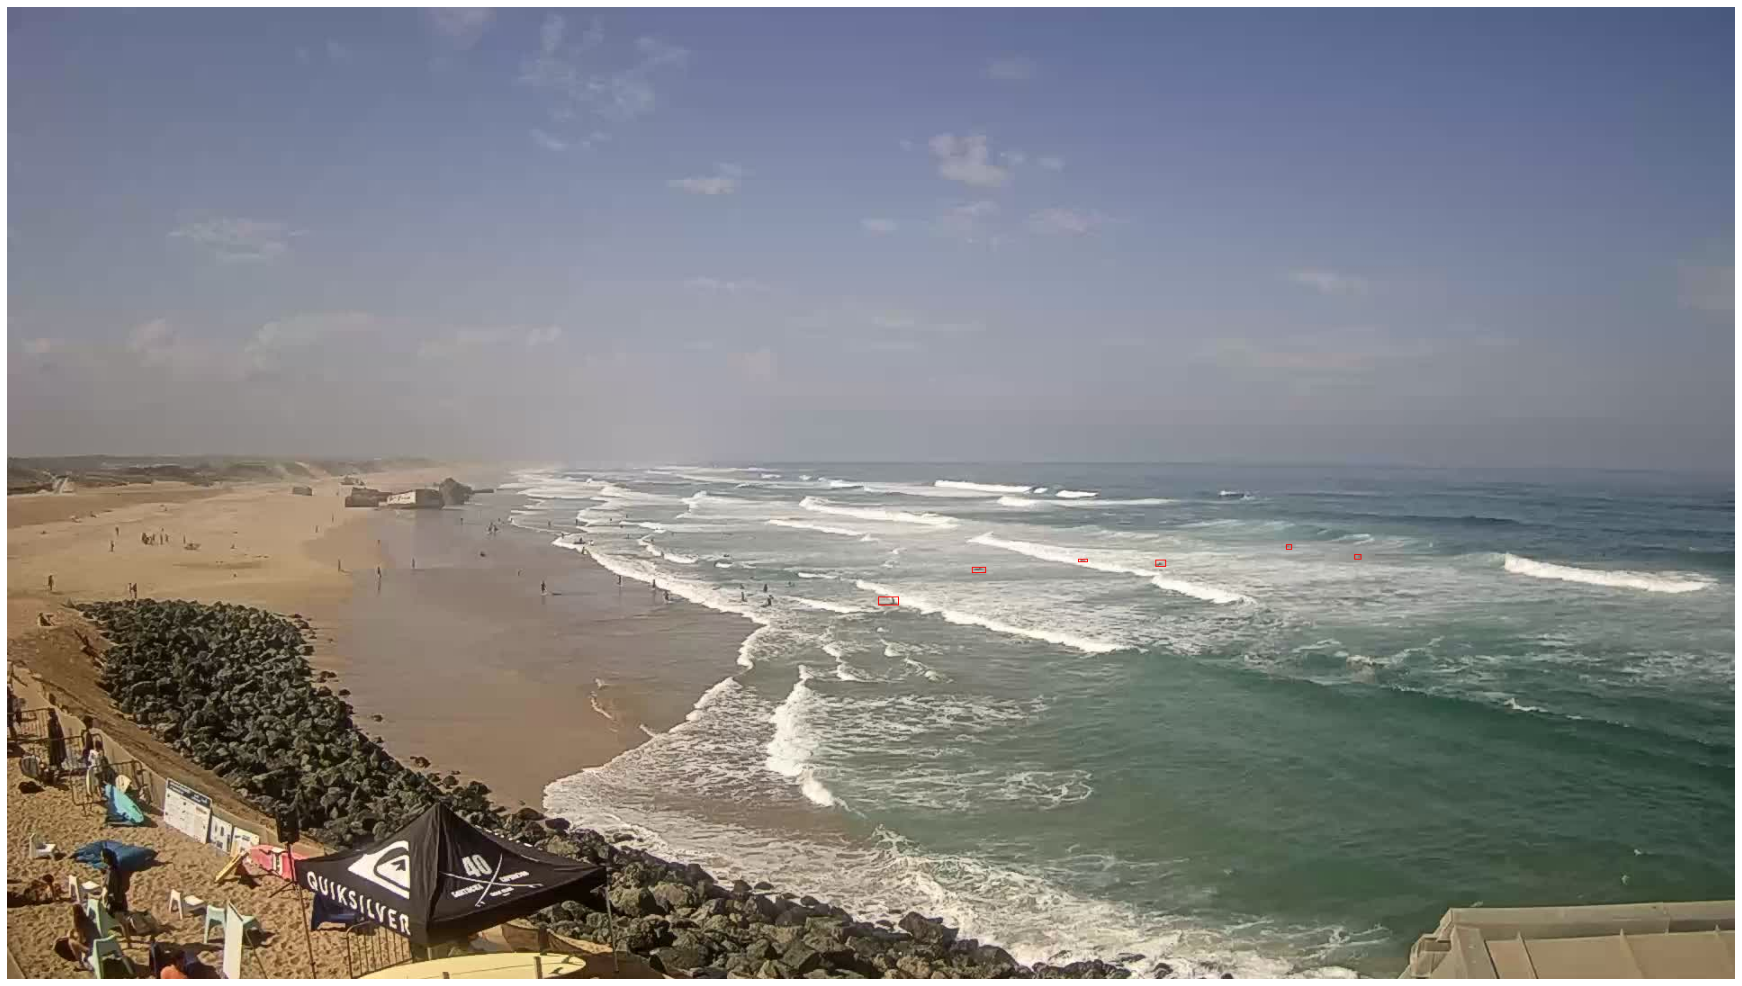

24


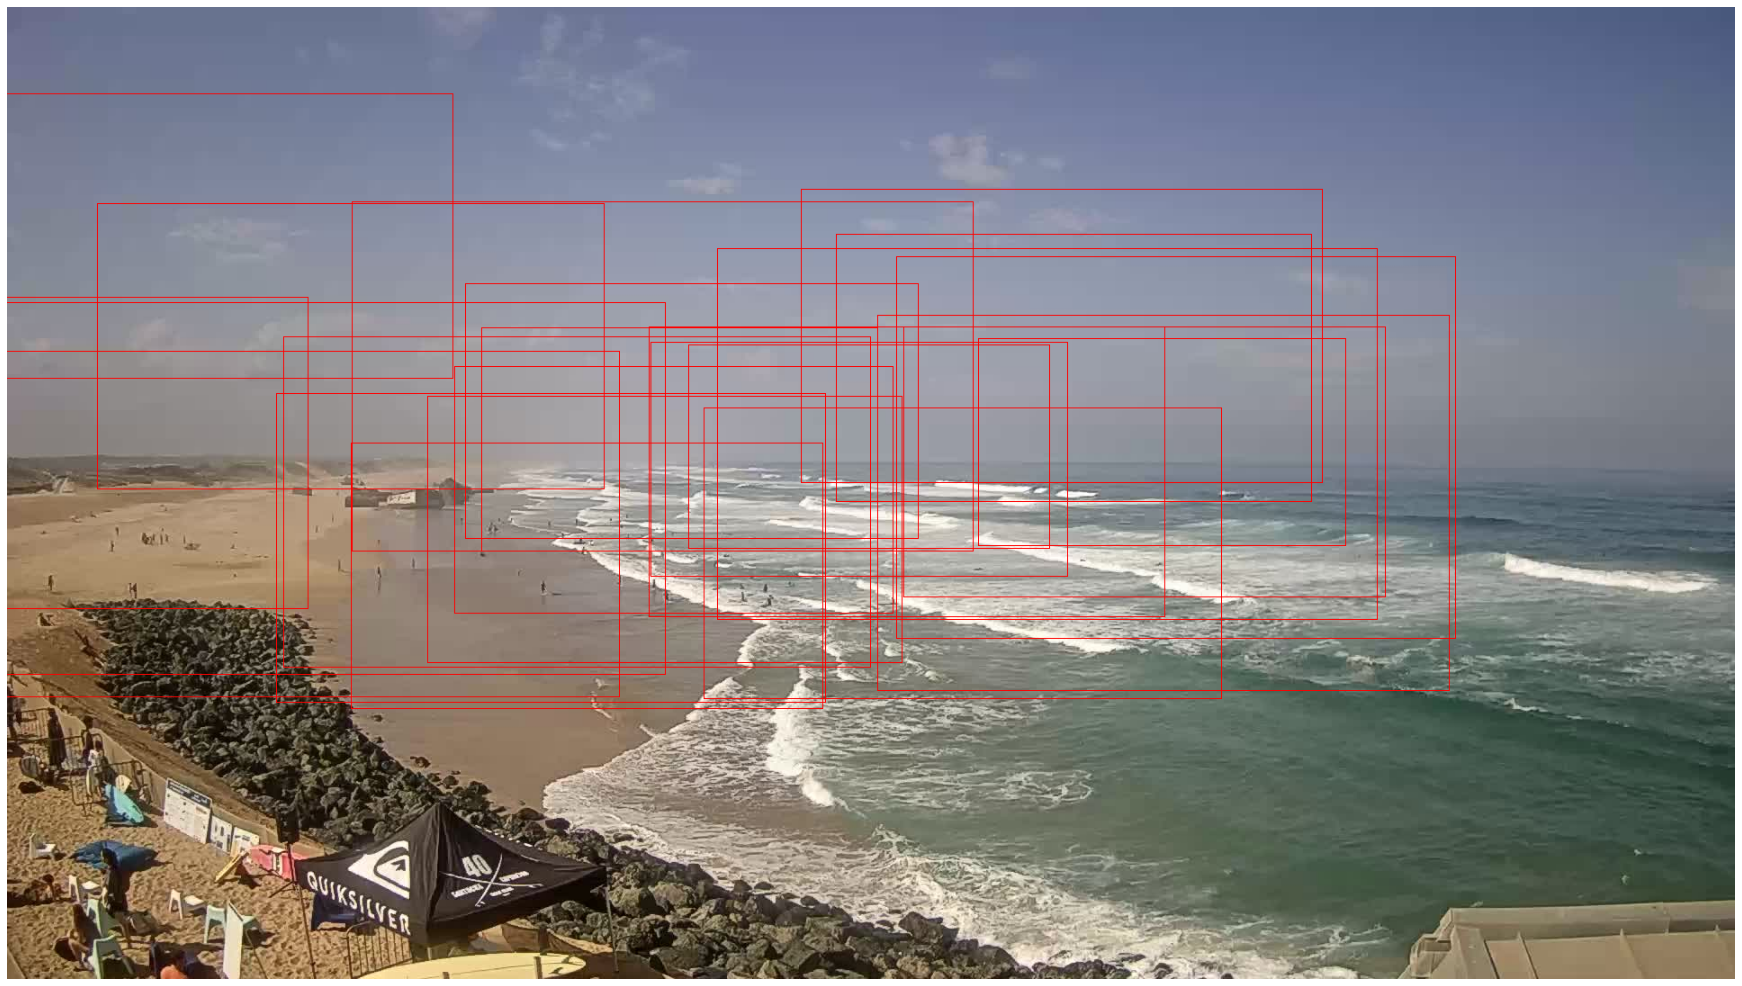

(734, 413)


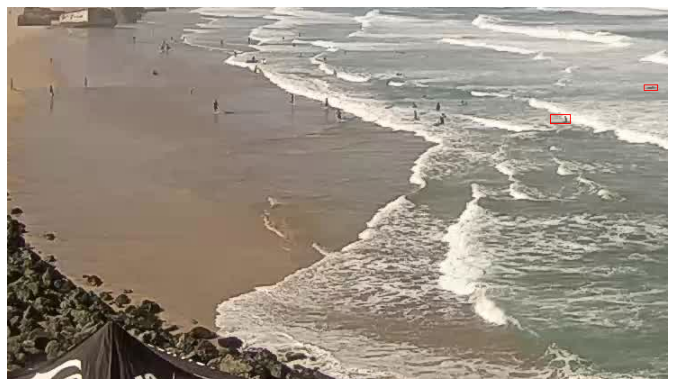

(525, 295)


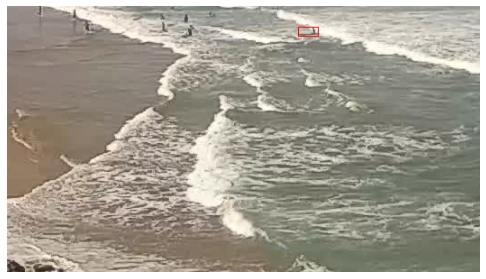

(527, 297)


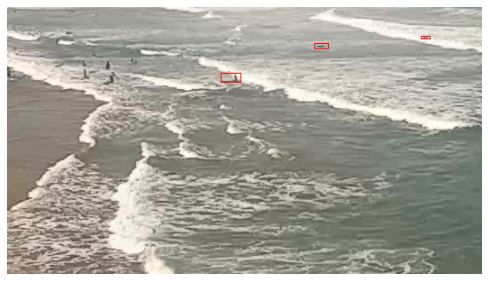

(733, 413)


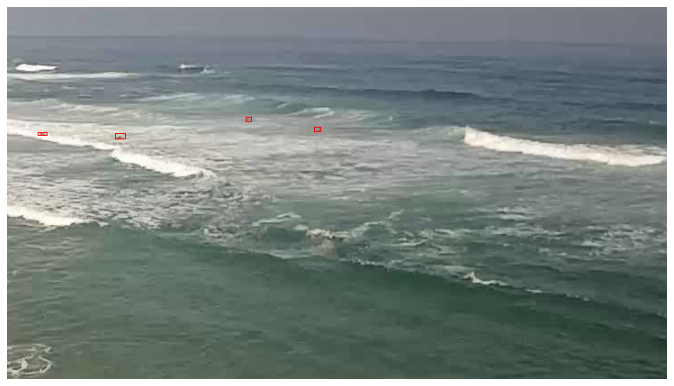

(535, 301)


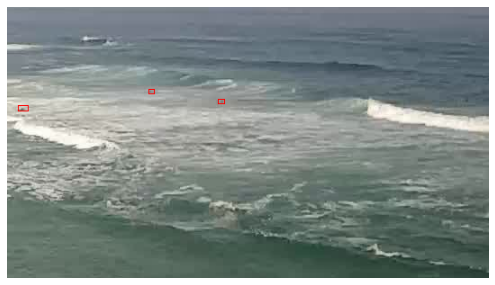

(401, 226)


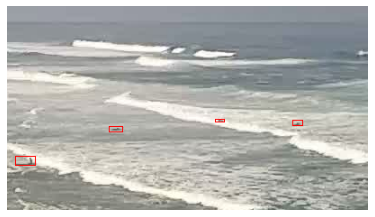

(610, 342)


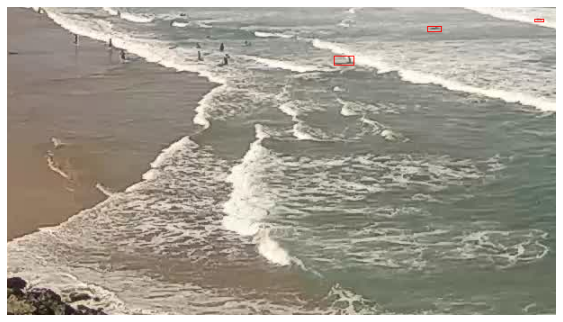

(487, 274)


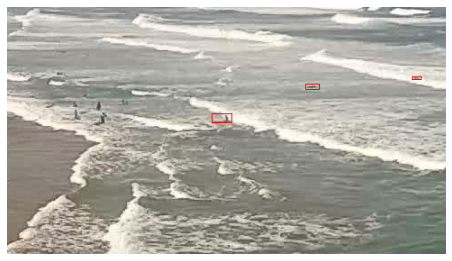

(463, 261)


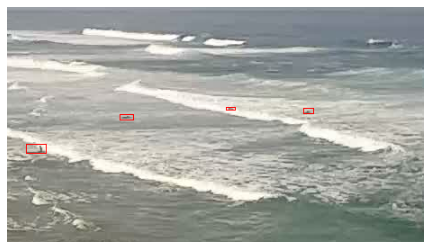

(503, 282)


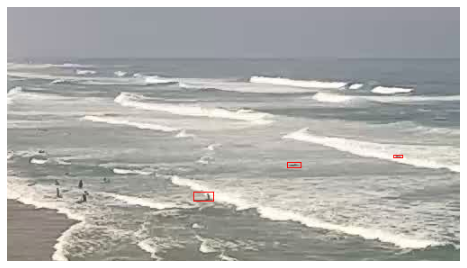

(635, 417)


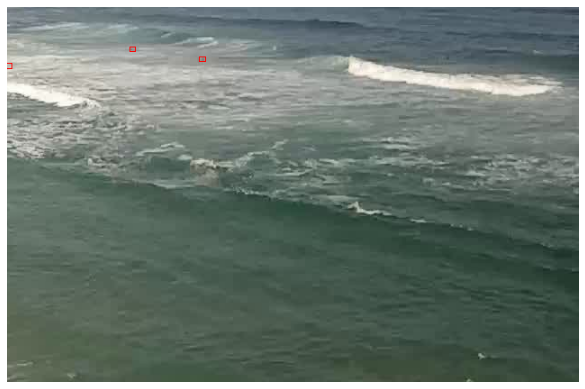

(575, 323)


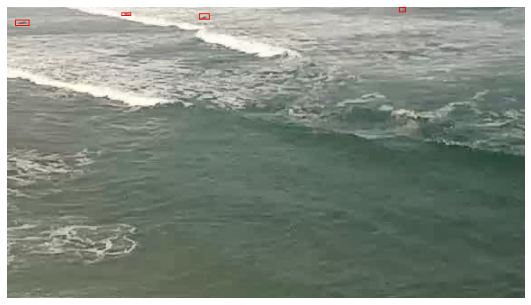

(691, 388)


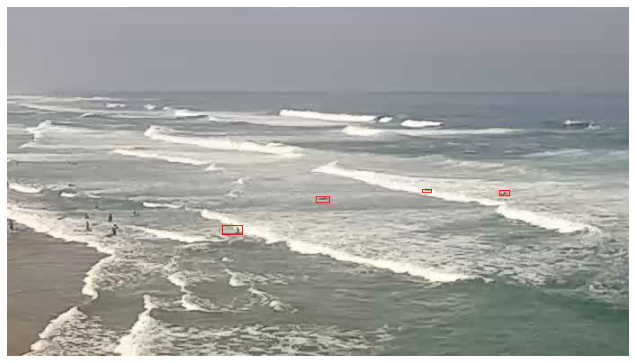

(621, 423)


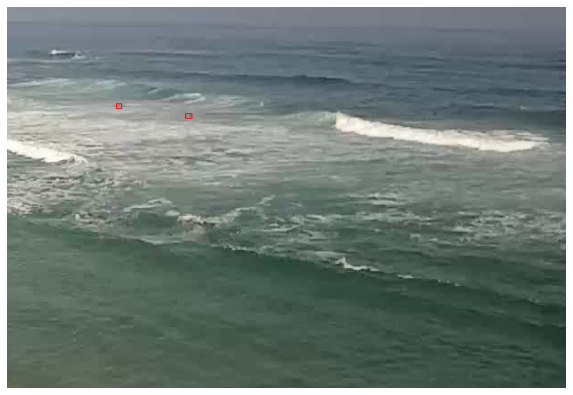

(408, 229)


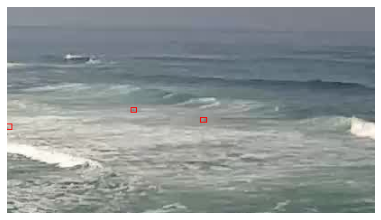

(579, 326)


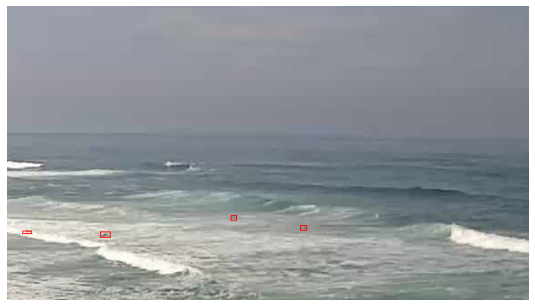

(573, 323)


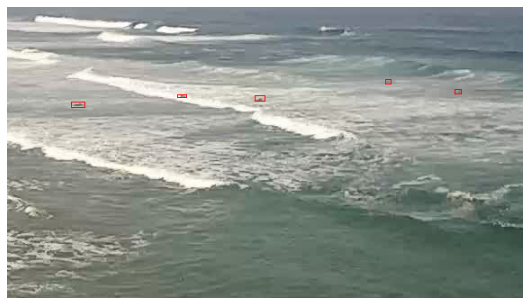

(652, 367)


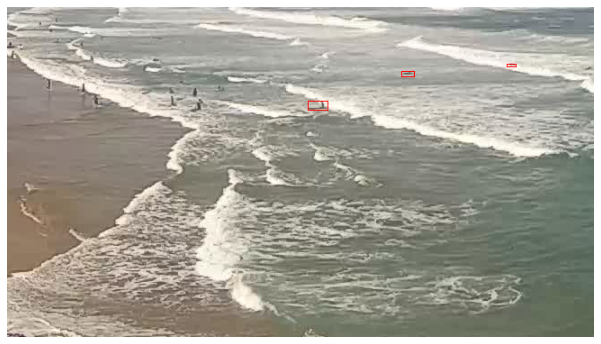

(528, 297)


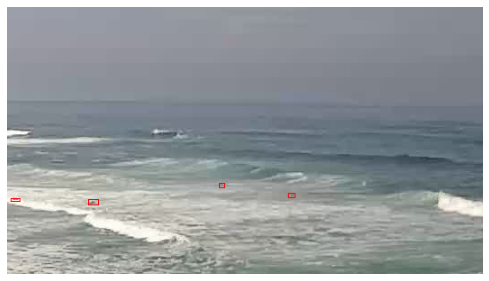

(683, 384)


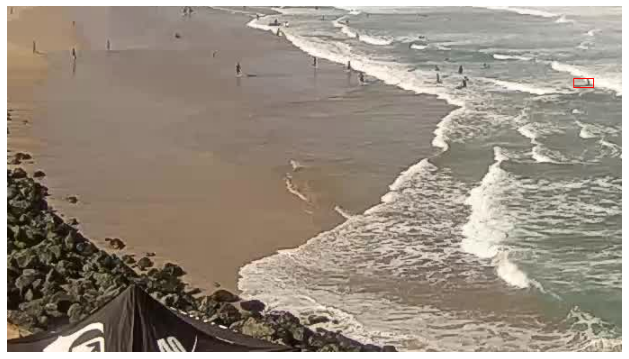

(562, 316)


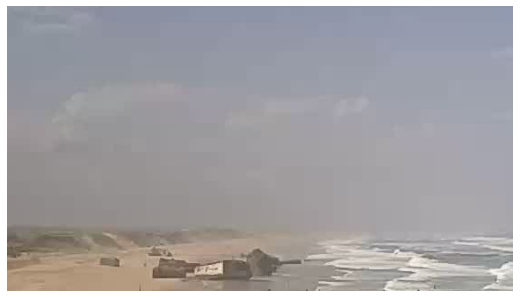

(563, 317)


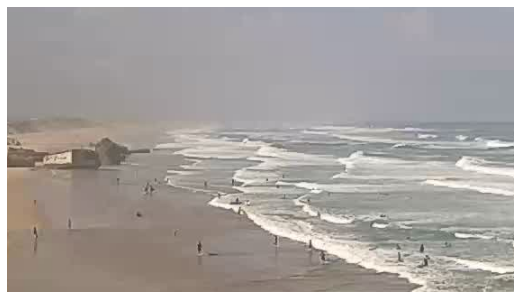

(440, 248)


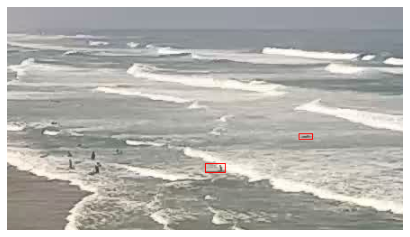

(615, 347)


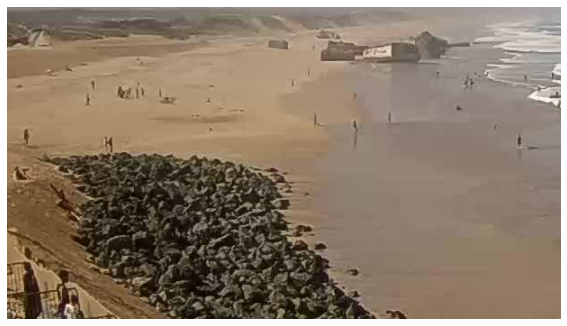

In [8]:
def prune_crops(crops, labels):
    new_crops = None
    for crop in crops:
        keep=False
        for label in labels:
            if bb_intersectionAB_over_A(label, crop)>0.9:
                keep = True
                break
        if keep or random.random() < 0.1:
            if new_crops is None:
                new_crops = [crop]
            else:
                new_crops = np.concatenate((new_crops, [crop]), axis=0)
    return new_crops


# label : [class, bb_x, bb_y, bb_width, bb_height]
# crop : [bb_x, bb_y, bb_width, bb_height]
# label and crop are on relative format (x,y) in [0,1]^2 to initial image
# return label in relative format to crop
def label_to_crop_label(label, crop, width, height):
    label[1] = (label[1] - crop[0])/ crop[2]
    label[2] = (label[2] - crop[1])/ crop[3]
    label[3] = label[3] / crop[2]
    label[4] = label[4] / crop[3]
    
    if label[2] < 0:
        label[2] = 0
    if label[1] < 0:
        label[1] = 0
    if label[1] + label[3] > 1:
        label[3] = 1 - label[1]
    if label[2] + label[4] > 1:
        label[4] = 1 - label[2]        
    return label
    
    
def make_cropped_images_labels(image_file_name, image, labels, crops):
    width, height = image.size
    images_labels = []
    image_names = []
    for i, crop in enumerate(crops):        
        new_labels = []
        for label in labels:
            if bb_intersectionAB_over_A(label, crop) > 0.6:
                new_labels.append(label_to_crop_label(label.copy(), crop, width, height))
        rectangle_crop = crop.copy()
        width, height = image.size
        rectangle_crop[2] = width * (crop[0]+crop[2])
        rectangle_crop[3] = height * (crop[1] + crop[3])
        rectangle_crop[0] *= width
        rectangle_crop[1] *= height
        small_image = image.crop(rectangle_crop)
        
        images_labels.append((small_image, new_labels))
        image_names.append(image_file_name.replace('.jpg', '_crop' + str(i) + '.jpg'))
    return image_names, images_labels
        
    
def split_image(image_txt_path):
    image_file_name = re.sub(".*?\\\\", "", image_txt_path.replace(".txt",".jpg"))
    image_path =  image_txt_path.replace(".txt",".jpg")
    
    labels = open(image_txt_path, "r").read()
    labels = np.array([[float(x) for x in row.split(" ")] for row in labels.split("\n") if row != ""])
    image = Image.open(os.path.join(image_path))
    h, w = image.size
    
    crops = random_crops(75,0.20,0.40)
    crops = prune_crops(crops, labels)
    if crops is not None:
        image_names, new_images_labels = make_cropped_images_labels(image_file_name, image, labels, crops)
    else:
        image_names, new_images_labels = None, None
    return image, labels, crops, image_names, new_images_labels


image, labels, crops, image_names, new_images_labels = split_image(annotation_files[11])

display_image_in_actual_size(image.copy(), labels)

if crops is not None:
    print(np.array(crops).shape[0])
    display_image_in_actual_size(image.copy(), [np.concatenate(([0], crop),axis=0) for crop in crops])
    for image, labels in new_images_labels:
        print(image.size)
        display_image_in_actual_size(image, labels)

In [9]:
def augment_and_save(annotation_files_list, split):
    os.mkdir('annotated/images/' + split)
    os.mkdir('annotated/labels/' + split)
    for annotation_file in tqdm(annotation_files_list):
        image, labels, crops, image_names, new_images_labels = split_image(annotation_file)
        if crops is not None:
            for image_name, (image, labels) in zip(image_names, new_images_labels):
                width, height = image.size
                new_width  = 640
                new_height = int(new_width * height / width)
                image = image.resize((new_width, new_height), Image.ANTIALIAS)
                image.save("annotated/images/" + split + "/" + image_name)

                with open("annotated/labels/" + split + "/" + image_name.replace(".jpg", ".txt"), 'w') as labels_file:
                        for i in range(len(labels)):
                            for j in range(4):
                                labels_file.write("%s " % labels[i][j])
                            labels_file.write("%s" % labels[i][4])
                            if i < len(labels) - 1:
                                labels_file.write("\n")
                                
                                
def save(annotation_files_list, split):
    os.mkdir('annotated/images/' + split)
    os.mkdir('annotated/labels/' + split)
    for annotation_file in tqdm(annotation_files_list):
        image_file_name = re.sub(".*?\\\\", "", annotation_file.replace(".txt",".jpg"))
        image_path = annotation_file.replace(".txt", ".jpg")

        labels = open(annotation_file, "r").read()
        labels = np.array([[float(x) for x in row.split(" ")] for row in labels.split("\n") if row != ""])
        image = Image.open(os.path.join(image_path))            
        width, height = image.size
        
        new_width  = 1920
        new_height = int(new_width * height / width)
        image = image.resize((new_width, new_height), Image.ANTIALIAS)
        image.save("annotated/images/" + split + "/" + image_file_name)

        with open("annotated/labels/" + split + "/" + image_file_name.replace(".jpg", ".txt"), 'w') as labels_file:
            for i in range(len(labels)):
                for j in range(4):
                    labels_file.write("%s " % labels[i][j])
                labels_file.write("%s" % labels[i][4])
                if i < len(labels) - 1:
                    labels_file.write("\n")

In [10]:
image_names

['Capbreton_Santosha__2022-06-11_08-46_crop0.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop1.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop2.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop3.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop4.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop5.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop6.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop7.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop8.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop9.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop10.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop11.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop12.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop13.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop14.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop15.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop16.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop17.jpg',
 'Capbreton_Santosha__2022-06-11_08-46_crop18.jpg',
 'Capbreton_Santosha__

In [11]:
n = len(annotation_files)
i_max_train = int(n*0.6)
i_max_val = i_max_train + int(n*0.2)

In [12]:
if not os.path.isdir('annotated'):
    os.mkdir('annotated')
if not os.path.isdir('annotated/images'):
    os.mkdir('annotated/images')
if not os.path.isdir('annotated/labels'):
    os.mkdir('annotated/labels')
    
save(annotation_files[i_max_train:i_max_val], 'val')
save(annotation_files[i_max_val:], 'test')
    
augment_and_save(annotation_files[:i_max_train], 'train')

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\alexa\AppData\Local\Temp\ipykernel_14684\1223736110.py:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 0/141 [00:00<?, ?it/s]C:\Users\alexa\AppData\Local\Temp\ipykernel_14684\1223736110.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((new_width, new_height), Image.ANTIALIAS)
100%|██████████| 141/141 [01:22<00:00,  1.71it/s]
